In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
from numpy import *
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import json
import pandas as pd

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
tf.config.list_physical_devices('GPU')

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [2]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 256, 256

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 3

DATASET_DIR = './/Screen_Capturing/Data/session_1/'

In [3]:
replace_dict = {"'mouse'":'"mouse"',"'click'":'"click"',"'keyboard'":'"keyboard"',"['":'["',"', '":'", "', "']":'"]'}

def clean_input(input):
    for key, value in replace_dict.items():
        input = input.replace(key, value)
    return input

def parse_dataset():
    with open(os.path.join(DATASET_DIR,'data.txt'), 'r', encoding="utf-8") as file:
        files_data = file.read().split("\n")
        
    records = []
    for file_data in files_data:
        if file_data == "":
            continue
        file_name, inputs = file_data.split("\t")
        inputs = clean_input(inputs)
        inputs = json.loads(inputs)
        file_name = file_name + ""
        data = inputs["mouse"][0], inputs["mouse"][1], inputs["click"][0], inputs["keyboard"], file_name
        records.append(data)

    return records

def pd_dataset(dataset):
    df = pd.DataFrame(dataset)
    df.columns = ['x', 'y', 'click', 'keyboard', 'file']

    return df

In [4]:
dataset = parse_dataset()
df = pd_dataset(dataset)
df.head(100)

,x,y,click,keyboard,file
0,0,0,,[],1
1,1509,347,Button.left,[],2
2,1509,347,,[],3
3,1509,347,,[],4
4,1509,347,,[],5
...,...,...,...,...,...
95,256,559,,[],96
96,255,549,,[],97
97,277,543,,[],98
98,432,526,,[],99


In [5]:
valid_keys_list = ['w','s','a','d','shift','e','q','1','2','r','ctrl','space']
valid_click_list = ["Button.left","Button.right"]


actions = ['click','for_back_move','left_right_move','shift','e','q','selection','r']

def clean_data(df):
    
    records = []

    for index, key in df.iterrows():
        data = [0]*12 
        keyboard_keys = str(key['keyboard'])
        keyboard_keys = keyboard_keys.replace("'", '"')
        keyboard_keys = json.loads(keyboard_keys)

        for i, action in enumerate(keyboard_keys):
            keyboard_keys[i] = str(action)
        

        data[0] = int(key['x'])
        data[1] = int(key['y'])

        data[2] = 1 if key['click'] == 'Button.left' else 2 if key['click'] == 'Button.right' else 0

        data[3] = 1 if 'w' in keyboard_keys else 2 if 's' in keyboard_keys else 0

        data[4] = 1 if 'a' in keyboard_keys else 2 if 'd' in keyboard_keys else 0


        if 'Key.shift' in keyboard_keys:
            data[5] = 1

        if 'e' in keyboard_keys:
            data[6] = 1

        if 'q' in keyboard_keys:
            data[7] = 1

        data[8] = 1 if '1' in keyboard_keys else 2 if '2' in keyboard_keys else 0

        if 'r' in keyboard_keys:
            data[9] = 1

        if 'ctrl' in keyboard_keys:
            data[10] = 1

        if '<32>' in keyboard_keys:
            data[11] = 1

        data.append(key['file'])

        records.append(data)
    return records

def pd_labels(dataset):
    df = pd.DataFrame(dataset)
    df.columns = ['x','y','click','for_back_move','left_right_move','shift','e','q','selection','r','ctrl','space','file']

    return df

clean_dataset = clean_data(df)
clean_df = pd_labels(clean_dataset)
pd.set_option('display.max_rows', None)
print(clean_df.head(5000))

         x     y  click  for_back_move  left_right_move  shift  e  q  \
0        0     0      0              0                0      0  0  0   
1     1509   347      1              0                0      0  0  0   
2     1509   347      0              0                0      0  0  0   
3     1509   347      0              0                0      0  0  0   
4     1509   347      0              0                0      0  0  0   
5     1509   347      0              0                0      0  0  0   
6     1509   347      0              0                0      0  0  0   
7     1509   347      0              0                0      0  0  0   
8     1509   347      0              0                0      0  0  0   
9     1509   347      0              0                0      0  0  0   
10    1495   349      0              0                0      0  0  0   
11    1483   356      0              0                0      0  0  0   
12    1483   356      0              0                0      0  

In [ ]:
clean_df['click'].values[10]

In [6]:
from keras.utils import to_categorical

print(clean_df['click'].values[0:10].shape)

toq = to_categorical(clean_df['click'].values)

toq.shape

(10,)


(36814, 3)

In [6]:
max_x = df['x'].max()
max_y = df['y'].max()

In [7]:
from PIL import Image

class DataGenerator():
    def __init__(self, df):
        self.df = df

    def generate_split_indexes(self):
        p = np.random.permutation(len(df))
        print(p)
        train_up_to = int(len(df))
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        train_up_to = int(train_up_to)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]


        self.max_x = df['x'].max()
        self.max_y = df['y'].max()
        return train_idx, valid_idx, test_idx

    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path).convert('RGB')
        im = cv2.resize(im, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)
        im = np.array(im) / 255.0
        
        return im

    def frame_extraction(self, index, df):

        frames_list = []
        for k in range(SEQUENCE_LENGTH):
            frame = np.array(Image.open(os.path.join(DATASET_DIR, str(self.df['file'].values[index-k]) + '.jpeg')))
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)
            frame = frame / 255.0
            frames_list.append(frame)

        return frames_list

    def labels_extraction(self, index, name, df):
        label_list = []
        for k in range(SEQUENCE_LENGTH):
            label = self.df[name].values[index-k]
            label_list.append(label)

        return label_list

    def generate(self, image_idx, is_training, batch_size=32):
        """
        Generates batches of samples
        """
        while True:
            frames_list = []
            labels = []
            x_labels_list = []
            y_labels_list = []
            click_labels_list = []
            for_back_move_labels_list = []
            left_right_move_labels_list = []
            shift_labels_list = []
            e_labels_list = []
            q_labels_list = []
            selection_labels_list = []
            r_labels_list = []
            ctrl_labels_list = []
            space_labels_list = []

            for idx in image_idx:
                if idx + SEQUENCE_LENGTH >= len(self.df):
                    continue
                if idx - SEQUENCE_LENGTH < 0:
                    continue

                if len(frames_list) != batch_size:
                    frames = self.frame_extraction(idx, self.df)
                    x_labels = self.labels_extraction(idx, 'x', self.df)
                    y_labels = self.labels_extraction(idx, 'y', self.df)
                    click_labels = self.labels_extraction(idx, 'click', self.df)
                    for_back_move_labels = self.labels_extraction(idx, 'for_back_move', self.df)
                    left_right_move_labels = self.labels_extraction(idx, 'left_right_move', self.df)
                    shift_labels = self.labels_extraction(idx, 'shift', self.df)
                    e_labels = self.labels_extraction(idx, 'e', self.df)
                    q_labels = self.labels_extraction(idx, 'q', self.df)
                    selection_labels = self.labels_extraction(idx, 'selection', self.df)
                    r_labels = self.labels_extraction(idx, 'r', self.df)
                    ctrl_labels = self.labels_extraction(idx, 'ctrl', self.df)
                    space_labels = self.labels_extraction(idx, 'space', self.df)

                    x_labels = np.array(x_labels)/self.max_x
                    y_labels = np.array(y_labels)/self.max_y

                    click_labels = np.array(click_labels)
                    for_back_move_labels = np.array(for_back_move_labels)
                    left_right_move_labels = np.array(left_right_move_labels)
                    shift_labels = np.array(shift_labels)
                    e_labels = np.array(e_labels)
                    q_labels = np.array(q_labels)
                    selection_labels = np.array(selection_labels)
                    r_labels = np.array(r_labels)
                    ctrl_labels = np.array(ctrl_labels)
                    space_labels = np.array(space_labels)
                    
                    frames_list.append(frames)

                    x_labels_list.append(x_labels)
                    y_labels_list.append(y_labels)
                    click_labels_list.append(click_labels)
                    for_back_move_labels_list.append(for_back_move_labels)
                    left_right_move_labels_list.append(left_right_move_labels)
                    shift_labels_list.append(shift_labels)
                    e_labels_list.append(e_labels)
                    q_labels_list.append(q_labels)
                    selection_labels_list.append(selection_labels)
                    r_labels_list.append(r_labels)
                    ctrl_labels_list.append(ctrl_labels)
                    space_labels_list.append(space_labels)



                if len(frames_list) == batch_size:
                    yield np.array(frames_list), [np.array(x_labels_list), np.array(y_labels_list), np.array(click_labels_list), np.array(for_back_move_labels_list), np.array(left_right_move_labels_list), np.array(shift_labels_list), np.array(e_labels_list), np.array(q_labels_list), np.array(selection_labels_list), np.array(r_labels_list), np.array(ctrl_labels_list), np.array(space_labels_list)]
                    """
                    frames_list = []
                    x_labels_list = []
                    y_labels_list = []
                    click_labels_list = []
                    for_back_move_labels_list = []
                    left_right_move_labels_list = []
                    shift_labels_list = []
                    e_labels_list = []
                    q_labels_list = []
                    selection_labels_list = []
                    r_labels_list = []
                    ctrl_labels_list = []
                    space_labels_list = []
                    """
            if not is_training:
                break
data_generator = DataGenerator(clean_df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

[16665  2819  8547 ... 18146  4761  4643]


In [8]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, ConvLSTM2D, MaxPooling2D, MaxPooling3D,BatchNormalization, Input, LSTM, TimeDistributed, Bidirectional,Conv3D, Rescaling
from keras.models import Sequential, Model
class create_ConvLSTM_model():

    def dense_block(self, inputs, units, activation="relu"):
        x = Dense(units)(inputs)
        x = Activation(activation)(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(0.2)(x)
        return x



    def build_x_position_branch(self, inputs, num_outputs=1):

        x = self.dense_block(inputs, 16)
        x = Dense(num_outputs)(x)
        x = Activation("linear", name='x')(x)
        return x

    def build_y_position_branch(self, inputs, num_outputs=1):

        x = self.dense_block(inputs, 16)
        x = Dense(num_outputs)(x)
        x = Activation("linear", name='y')(x)
        return x

    def build_softmax_branch(self, inputs, name, num_outputs=3):
        x = self.dense_block(inputs, 128)
        x = self.dense_block(x, 64)
        x = self.dense_block(x, 32)
        x = Dense(num_outputs)(x)
        x = Activation("softmax", name=name)(x)
        return x

    def build_action_branch(self, inputs, name, num_outputs=1):

        x = self.dense_block(inputs, 16)
        x = Dense(num_outputs)(x)
        x = Activation("sigmoid", name=name)(x)
        return x

    def build_model(self):
        '''
        This function will construct the required LRCN model.
        Returns:
            model: It is the required constructed LRCN model.
        '''

        # We will use a Sequential model for model construction.
        inputs = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

        x = Rescaling(1./255)(inputs)

        x = ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'relu',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True)(inputs)
        x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
        x = TimeDistributed(Dropout(0.5))(x)

        x = ConvLSTM2D(filters = 32, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True)(x)
        x = MaxPooling3D(pool_size=(1, 4, 4), padding='same', data_format='channels_last')(x)
        x = TimeDistributed(Dropout(0.5))(x)
        
        x = ConvLSTM2D(filters = 64, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                            recurrent_dropout=0.2, return_sequences=True)(x)
        x = MaxPooling3D(pool_size=(1, 8, 8), padding='same', data_format='channels_last')(x)
        x = TimeDistributed(Dropout(0.5))(x)

        """
        x = ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                            recurrent_dropout=0.2, return_sequences=True)(x)

        x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
        x = TimeDistributed(Dropout(0.2))(x)
        """

        x = Flatten()(x)
        x = self.dense_block(x, 1024)
        x = self.dense_block(x, 512)
        x = self.dense_block(x, 256)
        x = self.dense_block(x, 128)

        x_position = self.build_x_position_branch(x)
        y_position = self.build_y_position_branch(x)
        click = self.build_softmax_branch(x, "click")
        for_back_move = self.build_softmax_branch(x, "for_back_move")
        left_right_move = self.build_softmax_branch(x, "left_right_move")
        shift = self.build_action_branch(x, "shift")
        e = self.build_action_branch(x, "e")
        q = self.build_action_branch(x, "q")
        selection = self.build_softmax_branch(x, "selection")
        r = self.build_action_branch(x, "r")
        ctrl = self.build_action_branch(x, "ctrl")
        space = self.build_action_branch(x, "space")

        model = Model(inputs=inputs, outputs=[x_position, y_position, click, for_back_move, left_right_move, shift, e, q, selection, r, ctrl, space])

        return model

model = create_ConvLSTM_model().build_model()

In [ ]:
model.summary()

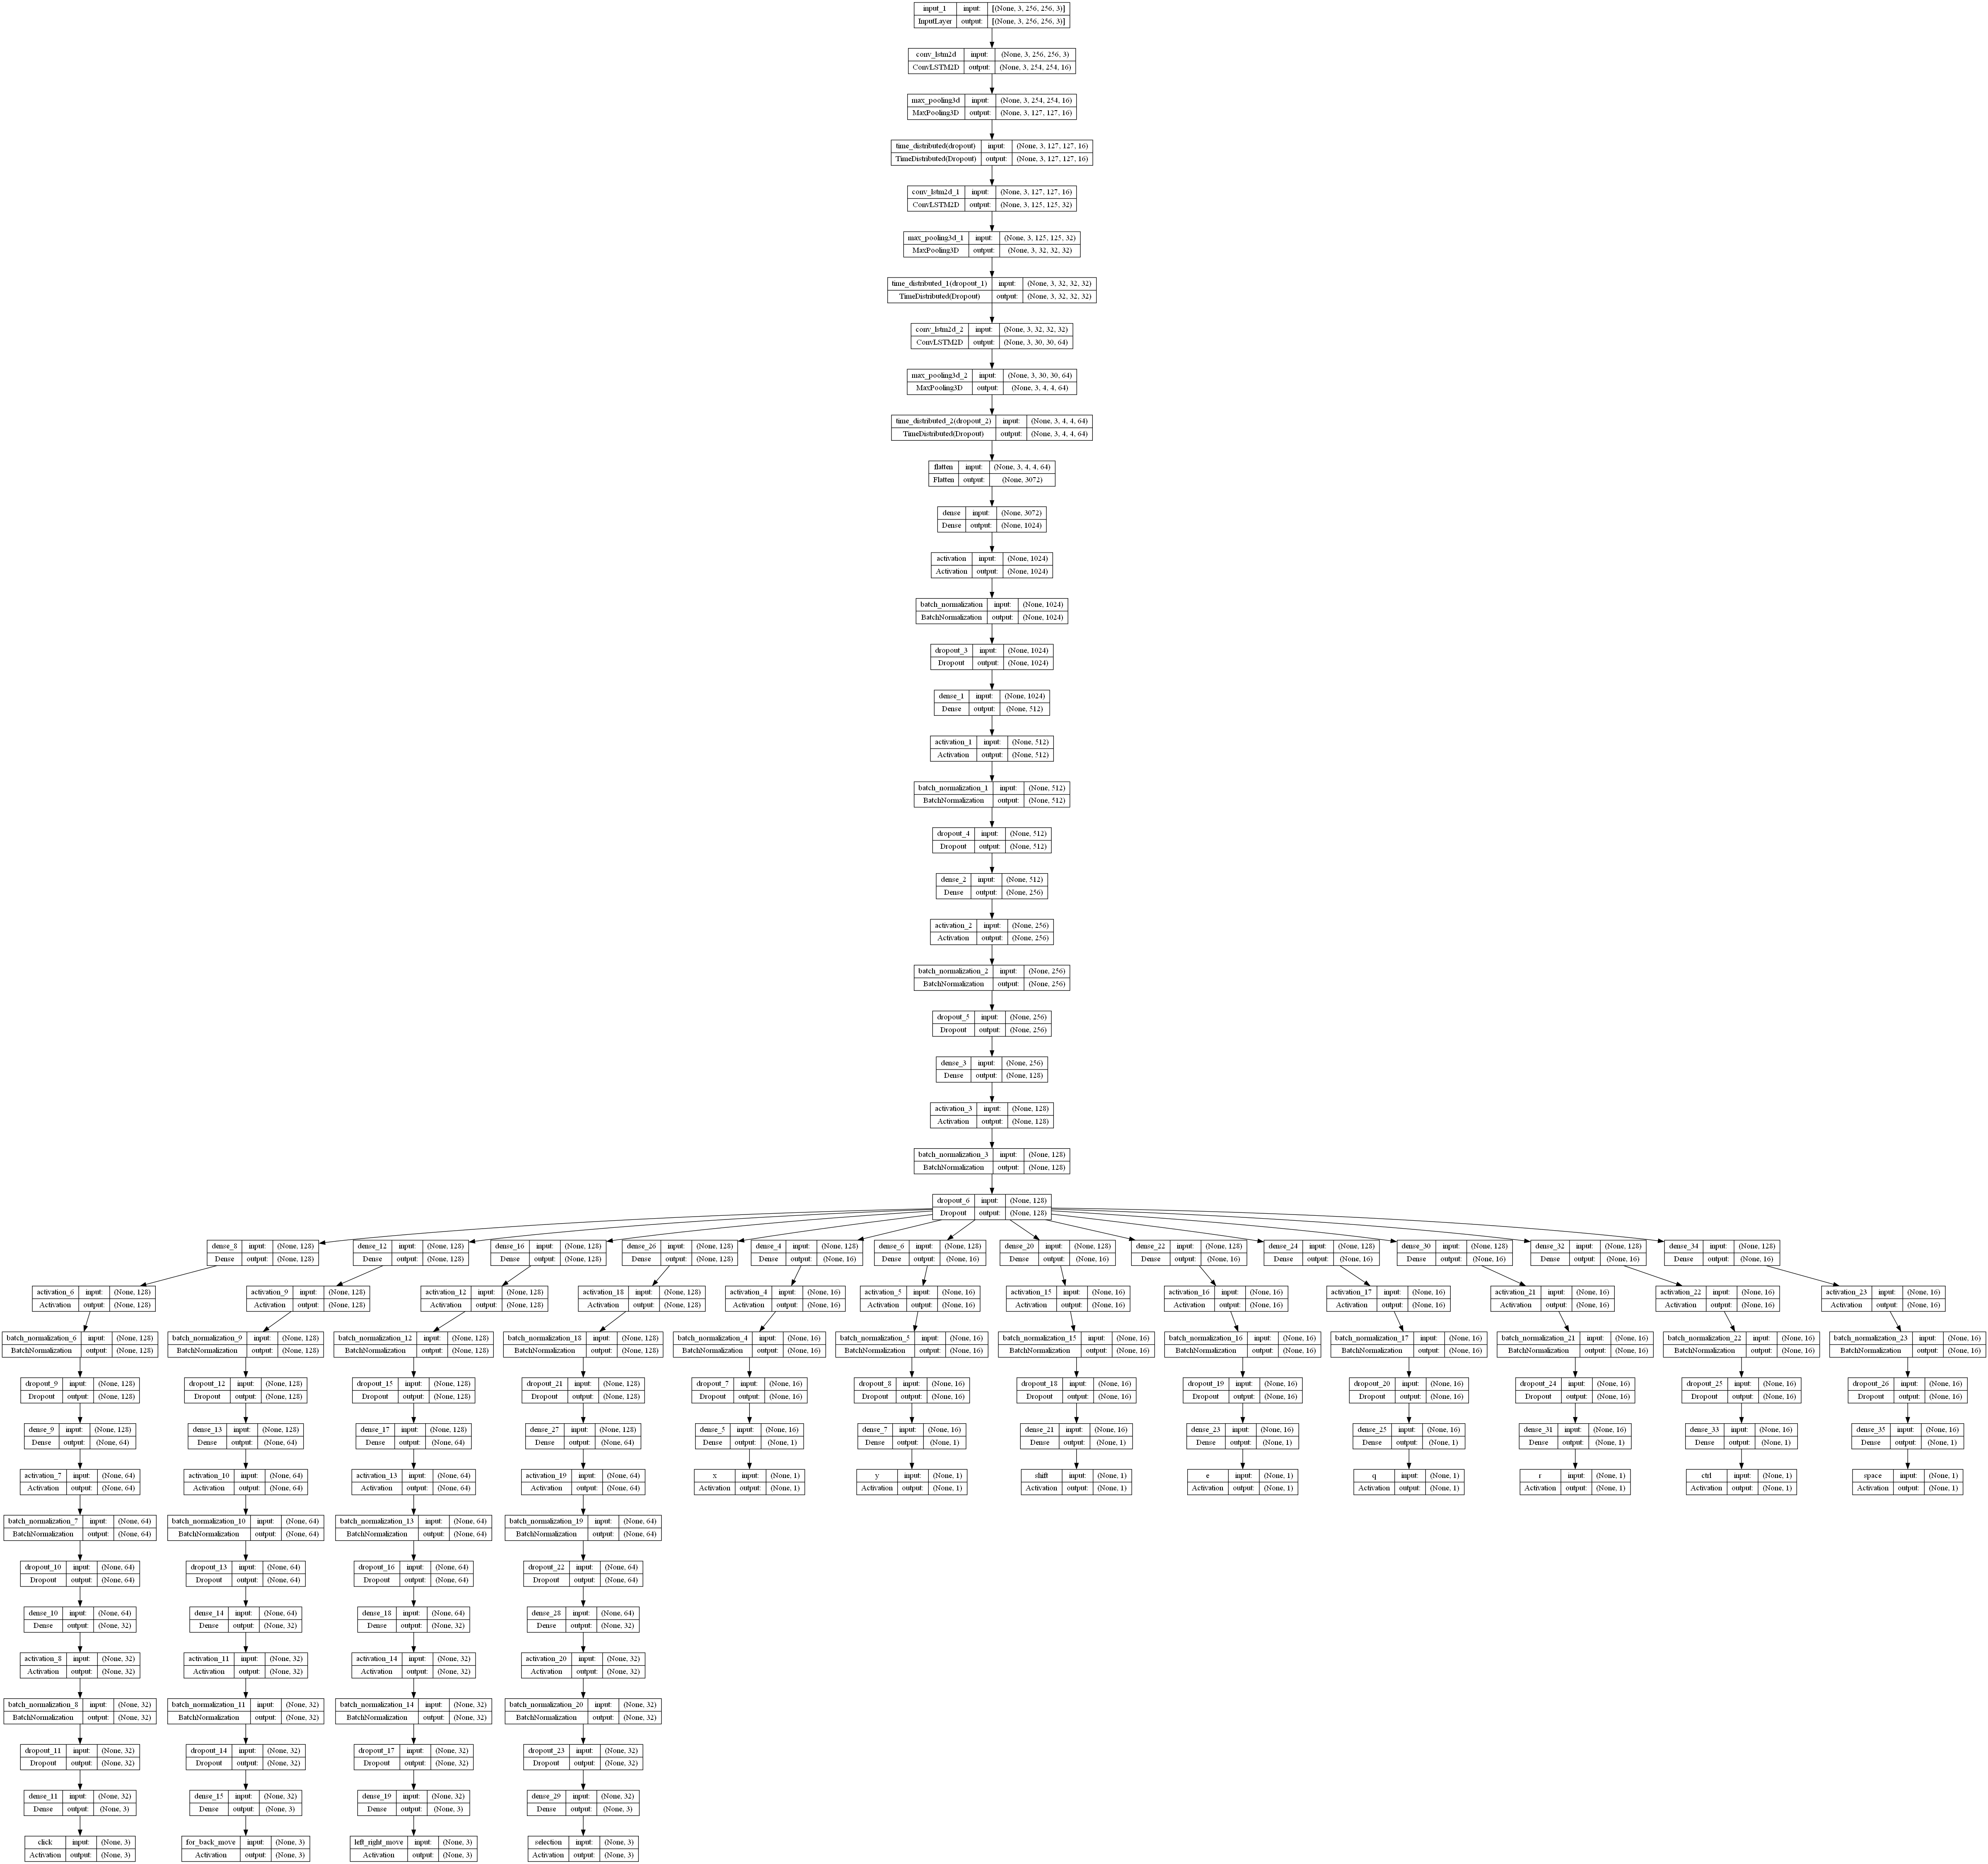

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [9]:
from keras.optimizers import Adam
init_lr = 1e-4
epochs = 25
opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)
# , decay=init_lr / epochs
binary_actions = ['shift', 'e', 'q', 'r', 'ctrl', 'space']

categorical_actions = ['click', 'for_back_move', 'left_right_move','selection']

loss = {'x': 'mse', 'y': 'mse'}
for index, key in enumerate(binary_actions):
    loss[key] = 'binary_crossentropy'
for index, key in enumerate(categorical_actions):
    loss[key] = 'categorical_crossentropy'
"""
loss_weights = {'x': 1.0, 'y': 1.0}
for index, key in enumerate(binary_actions):
    loss_weights[key] = 0.5
for index, key in enumerate(categorical_actions):
    loss_weights[key] = 2.0
"""
metrics = {'x': 'mae', 'y': 'mae'}
for index, key in enumerate(binary_actions):
    metrics[key] = 'accuracy'
for index, key in enumerate(categorical_actions):
    metrics[key] = 'categorical_accuracy'

model.compile(optimizer=opt, 
              loss=loss,
              #loss_weights=loss_weights,
              metrics=metrics)

In [13]:
from keras.callbacks import ModelCheckpoint
batch_size = 64
train_gen = data_generator.generate(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate(valid_idx, is_training=True, batch_size=batch_size)
callbacks = {
    'checkpoint': ModelCheckpoint('model-{epoch:03d}.h5', monitor='loss', verbose=0, save_best_only=True, mode='auto'),
}

step_size_train = len(train_idx)//batch_size
step_size_train = 30
step_size_valid = len(valid_idx)//batch_size

model.load_weights('model-007.h5')

history = model.fit(train_gen,
                    steps_per_epoch=step_size_train,
                    epochs=epochs, 
                    callbacks=[callbacks['checkpoint']])

Epoch 1/25
30/30 [==============================] - 3797s 126s/step - loss: 14.3810 - x_loss: 0.8135 - y_loss: 1.2988 - click_loss: 1.5836 - for_back_move_loss: 3.1861 - left_right_move_loss: 2.6343 - shift_loss: 0.8535 - e_loss: 0.7694 - q_loss: 0.7831 - selection_loss: 0.0000e+00 - r_loss: 0.8402 - ctrl_loss: 0.8220 - space_loss: 0.7965 - x_mae: 0.7029 - y_mae: 0.8465 - click_categorical_accuracy: 0.3115 - for_back_move_categorical_accuracy: 0.3380 - left_right_move_categorical_accuracy: 0.3182 - shift_accuracy: 0.5193 - e_accuracy: 0.5262 - q_accuracy: 0.5443 - selection_categorical_accuracy: 0.2844 - r_accuracy: 0.5547 - ctrl_accuracy: 0.5141 - space_accuracy: 0.5391
Epoch 2/25
30/30 [==============================] - 3807s 127s/step - loss: 14.1217 - x_loss: 0.7389 - y_loss: 1.2244 - click_loss: 1.5390 - for_back_move_loss: 3.1835 - left_right_move_loss: 2.6418 - shift_loss: 0.8210 - e_loss: 0.7677 - q_loss: 0.7951 - selection_loss: 0.0000e+00 - r_loss: 0.8308 - ctrl_loss: 0.8016 

In [14]:
model.load_weights('model-008.h5')

In [ ]:
model.save('model.h5')

In [15]:
def process_img(img):
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT)).convert('RGB')
    img = np.array(img) / 255.0
    return img

def pred_frame(img_past, img_present, img_future):
    img_past_list, img_present_list, img_future_list = [], [], []


    img_past = process_img(img_past)
    img_present = process_img(img_present)
    img_future = process_img(img_future)

    images = [np.array(img_past), np.array(img_present), np.array(img_future)]
    #print(np.array(images).shape)

    x_pred, y_pred, click_pred, for_back_move_pred, left_right_move_pred, shift_pred, e_pred, q_pred, selection_pred, r_pred, ctrl_pred, space_pred = model.predict(np.expand_dims(images, axis = 0), verbose=0)
    
    click_pred, for_back_move_pred, left_right_move_pred, shift_pred, e_pred, q_pred, selection_pred, r_pred, ctrl_pred, space_pred = click_pred.argmax(axis=-1), for_back_move_pred.argmax(axis=-1), left_right_move_pred.argmax(axis=-1), shift_pred.argmax(axis=-1), e_pred.argmax(axis=-1), q_pred.argmax(axis=-1), selection_pred.argmax(axis=-1), r_pred.argmax(axis=-1), ctrl_pred.argmax(axis=-1), space_pred.argmax(axis=-1)

    x_pred, y_pred = x_pred * max_x, y_pred * max_y

    print(click_pred, for_back_move_pred, left_right_move_pred, shift_pred)

    return x_pred[0], y_pred[0], click_pred[0], for_back_move_pred[0], left_right_move_pred[0], shift_pred[0], e_pred[0], q_pred[0], selection_pred[0], r_pred[0], ctrl_pred[0], space_pred[0]


In [16]:
import win32gui
from PIL import ImageGrab
from time import time
import cv2 as cv
from pynput.mouse import Listener as MouseListener
from pynput.keyboard import Listener as KeyboardListener
from pynput.keyboard import Key

loop_time = time()
first_frame = True
ind = 0


screenshot = None
past_screenshot = None
past_1_screenshot = None
past_2_screenshot = None
past_3_screenshot = None

color = (255, 0, 0)

while(True):
    ind += 1
    # print(ind)
    hwnd = win32gui.FindWindow(None, 'Overwatch')
    rect = win32gui.GetWindowRect(hwnd)
    screenshot = ImageGrab.grab(bbox=(rect[0], rect[1], rect[2], rect[3]))

    """screenshot = np.array(screenshot)
    screenshot = cv.cvtColor(screenshot, cv.COLOR_RGB2BGR)"""

    if ind <= 2:
        past_screenshot = screenshot
        continue
    """
    if ind <= 3:
        past_1_screenshot = past_screenshot
        past_screenshot = screenshot
        continue

    if ind <= 4:
        past_2_screenshot = past_1_screenshot
        past_1_screenshot = past_screenshot
        past_screenshot = screenshot
        continue

    if ind <= 5:
        past_3_screenshot = past_2_screenshot
        past_2_screenshot = past_1_screenshot
        past_1_screenshot = past_screenshot
        past_screenshot = screenshot
        continue
    """
    #past_3_screenshot = past_2_screenshot
    #past_2_screenshot = past_1_screenshot
    past_1_screenshot = past_screenshot
    past_screenshot = screenshot


    x_pred, y_pred, click_pred, for_back_move_pred, left_right_move_pred, shift_pred, e_pred, q_pred, selection_pred, r_pred, ctrl_pred, space_pred = pred_frame(screenshot, past_screenshot, past_1_screenshot)

    screenshot = np.array(screenshot)

    if click_pred == 1:
        color = (0, 255, 0)
    elif click_pred == 2:
        color = (0, 0, 255)
    else:
        color = (255, 0, 0)
    screenshot = cv2.circle(screenshot, (int(x_pred), int(y_pred)), 5, color, -1)

    screenshot = cv.cvtColor(screenshot, cv.COLOR_RGB2BGR)

    cv.imshow('Computer Vision', screenshot)

    print('FPS {}'.format(1 / (time() - loop_time)))
    loop_time = time()
    if cv.waitKey(1) == ord('q'):
        break

cv.destroyAllWindows()

error: (1400, 'GetWindowRect', 'Invalid window handle.')